#### Load the required libraries 

In [1]:
import os 
os.chdir('.')
os.listdir('.')

['Customer_Segmenatation_Student_Copy.ipynb',
 'image.html',
 'online12M.csv',
 'Customer_Segmenatation .ipynb',
 '.ipynb_checkpoints']

In [2]:
import time as time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly.express as px

#### Read the data 

In [3]:
online = pd.read_csv('online12M.csv',index_col=0)

In [4]:
online.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom
125615,547051,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-03-20,0.42,12902,United Kingdom
483123,577493,20724,RED RETROSPOT CHARLOTTE BAG,10,2011-11-20,0.85,17323,United Kingdom
449888,575143,23343,JUMBO BAG VINTAGE CHRISTMAS,10,2011-11-08,2.08,13643,United Kingdom
127438,547223,22934,BAKING MOULD EASTER EGG WHITE CHOC,2,2011-03-21,2.95,12867,United Kingdom
189515,553156,21212,PACK OF 72 RETROSPOT CAKE CASES,2,2011-05-13,0.55,17841,United Kingdom


#### Basic details of the dataset like count of rows ,columns and names of columns

In [5]:
print(f'Number of rows in the dataset = {online.shape[0]}')
print(f'Number of Columns in the datset ={online.shape[1]}')
print(f'The name of the columns are : {list(online.columns)}')

Number of rows in the dataset = 68176
Number of Columns in the datset =8
The name of the columns are : ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


#### Check for the Missing Values

In [6]:
online.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

#### Get the details of the data types

In [7]:
online.dtypes

InvoiceNo        int64
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID       int64
Country         object
dtype: object

#### Changing the columns to the required data type

In [8]:
online['CustomerID'] = online['CustomerID'].astype('category')

In [9]:
cat_cols  = online.select_dtypes('object').columns
online[cat_cols] = online[cat_cols].astype('category')


In [10]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

#### Get the summary statistics 

In [11]:
online.describe(include=['float64','int64'])

,InvoiceNo,Quantity,UnitPrice
count,68176.000000,68176.000000,68176.000000
mean,561562.235904,11.556119,3.069209
std,12570.817828,41.133000,32.513232
min,538172.000000,1.000000,0.001000
25%,550512.000000,2.000000,1.250000
50%,562779.000000,4.000000,1.850000
75%,572650.000000,12.000000,3.750000
max,581586.000000,4300.000000,8142.750000


In [12]:
online.describe(exclude=['float64','int64'])

,StockCode,Description,InvoiceDate,CustomerID,Country
count,68176,68176,68176,68176,68176
unique,3185,3305,297,3643,1
top,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-12-05 00:00:00,17841,United Kingdom
freq,353,353,660,1497,68176


#### Get the total  number of Customers

In [13]:
online['CustomerID'].nunique()

3643

#### Get the details of the unique features for all the Categorical columns with their value counts

In [14]:
for col in cat_cols:
    print(col,online[col].nunique())
    

StockCode 3185
Description 3305
InvoiceDate 297
Country 1


#### Add a column TotalSum by multiplying Quantity with unit Price

In [15]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']

#### Find the min and max dates from the InvoiceDate

In [16]:
Max_Date=max((online['InvoiceDate']).dt.date) 
Min_Date=min((online['InvoiceDate']).dt.date)
print(f'Max_Date = {Max_Date} , Min_Date={Min_Date}')

Max_Date = 2011-12-09 , Min_Date=2010-12-10


#### Select a snap shot date to find the RFM

In [17]:
snap_shot_date = Max_Date+dt.timedelta(days=1)
print(f'snap_shot_date={snap_shot_date}')


snap_shot_date=2011-12-10


#### Aggregating on the CustomerID

In [18]:
custlevelagg = online.groupby('CustomerID').agg({'InvoiceDate':lambda x:(snap_shot_date-x.dt.date.max()).days,
'InvoiceNo':'count',
'TotalSum':'sum'}).reset_index()

In [19]:
custlevelagg.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'Monetary'},inplace=True)

In [20]:
custlevelagg.head()

,CustomerID,Recency,Frequency,Monetary
0,12747,3,25,948.70
1,12748,1,888,7046.16
2,12749,4,37,813.45
3,12820,4,17,268.02
4,12822,71,9,146.15


#### Drop the CustomerID not relevant for Analysis 

In [21]:
custlevelaggrfm = custlevelagg.drop('CustomerID',axis=1)

#### Since Clustering  uses distances  variation in scales for different columns will be a problem (As big numbers dominate the distances)

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(custlevelaggrfm)
custlevelaggrfm_normalized = scaler.transform(custlevelaggrfm)


#### Instantiate the Kmeans Model

In [23]:
kmeans = KMeans(n_clusters=2,random_state=123)

In [24]:
kmeans.fit(custlevelaggrfm_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [25]:
cluster_labels = kmeans.labels_
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [26]:
rfm_k2 = custlevelaggrfm.assign(Cluster = cluster_labels)

In [27]:
rfm_k2.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean','Monetary':['mean','count']}).reset_index()

Cluster     Recency  Frequency    Monetary      
                 mean       mean        mean count
0       0   40.134601  23.282998  465.289053  2682
1       1  230.817898   5.963580  106.695536   961

In [28]:
labels = kmeans.predict(custlevelaggrfm_normalized)
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [29]:
from sklearn.metrics import silhouette_score
cluster_metrics = {'k':[],'sse':[],'silhoutte_score':[]}
for k in range(2,11):
    kmeans = KMeans(k,random_state=1)
    kmeans.fit(custlevelaggrfm_normalized)
    labels = kmeans.predict(custlevelaggrfm_normalized)
    cluster_metrics['k'].append(k)
    cluster_metrics['sse'].append(kmeans.inertia_)
    cluster_metrics['silhoutte_score'].append(silhouette_score(custlevelaggrfm_normalized,labels=labels))
    

In [30]:
pd.DataFrame.from_dict(cluster_metrics)

,k,sse,silhoutte_score
0,2,7883.328456,0.556158
1,3,5020.781055,0.583532
2,4,3710.601086,0.584377
3,5,2700.878095,0.606559
4,6,1960.092471,0.582920
5,7,1590.271342,0.520347
6,8,1337.383848,0.494925
7,9,1171.705865,0.467878
8,10,1055.650951,0.455670


#### Plot for the SSE


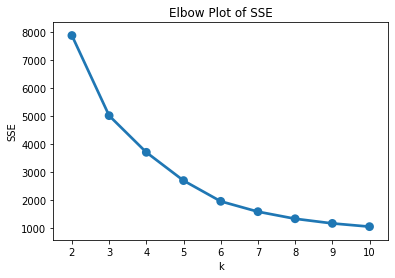

In [31]:

plt.title("Elbow Plot of SSE")
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x =cluster_metrics['k'] ,y =  cluster_metrics['sse'])
plt.show()

* Selecting the number of Cluster through elbow plot the value of k should be 5

In [32]:
kmeans = KMeans(n_clusters=5,random_state=123)

In [33]:
kmeans.fit(custlevelaggrfm_normalized)
rfm_k5 = custlevelaggrfm.assign(Cluster = kmeans.labels_)

In [34]:
rfm_k5.head()

,Recency,Frequency,Monetary,Cluster
0,3,25,948.70,3
1,1,888,7046.16,2
2,4,37,813.45,3
3,4,17,268.02,3
4,71,9,146.15,3


In [35]:
rfm_k5.groupby('Cluster').agg({'Recency':'mean','Frequency':'mean','Monetary':['mean','count']})

Recency    Frequency      Monetary      
               mean         mean          mean count
Cluster                                             
0         15.027778   103.672222   2519.397833   180
1        235.036916     6.044517    106.879631   921
2          2.666667  1146.666667   9293.950000     3
3         43.461569    15.911707    270.559267  2537
4          6.500000    70.000000  42110.595000     2

In [36]:
rfm_k5['Cluster'].value_counts()

3    2537
1     921
0     180
2       3
4       2
Name: Cluster, dtype: int64

In [37]:
rfm_k5['Cluster'] = rfm_k5['Cluster'].astype('category')

In [38]:
import plotly.express as px
fig = px.scatter_3d(rfm_k5, x='Recency', y='Frequency', z='Monetary',
              color='Cluster')
fig.write_html("image.html")

In [39]:
custlevelagg.columns

Index(['CustomerID', 'Recency', 'Frequency', 'Monetary'], dtype='object')

<IPython.core.display.Javascript object>


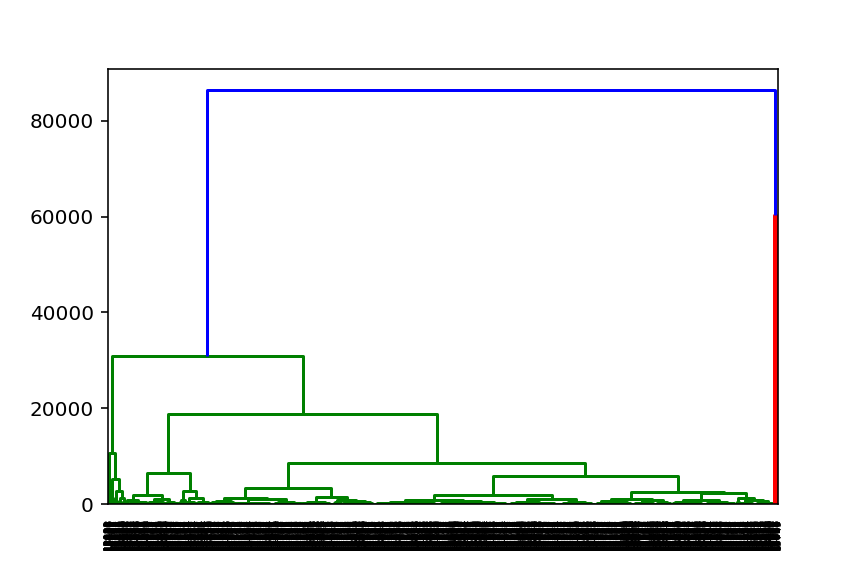

In [51]:
%matplotlib notebook
#Import Linkage and Dendrogram from scipy library.

from scipy.cluster.hierarchy import linkage, dendrogram
#2. Build the linkage matrix for the data.
linkage_matrix = linkage(custlevelaggrfm,method='ward',metric='euclidean')
#3. Using the linkage matrix build the Dendrogram.
dendrogram(linkage_matrix,labels=custlevelagg['CustomerID'].values)
#4. What is the ideal number of clusters from the above plot?
#5. Import Heirchal clustering from Sklearn.
plt.show()

In [41]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
print("Compute Structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(custlevelaggrfm_normalized)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)


Compute Structured hierarchical clustering...
Elapsed time: 0.34s
Number of points: 3643


#### DBScan Clustering

In [42]:
from sklearn.cluster import DBSCAN

In [43]:
cluster  = DBSCAN(metric='euclidean')

In [44]:
cluster.fit(custlevelaggrfm_normalized)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [45]:
labels = cluster.labels_

In [46]:
np.unique(labels)

array([-1,  0,  1,  2])

In [47]:
len(labels)

3643

In [48]:
dbscan_rfm = custlevelaggrfm.assign(Cluster = labels)

In [49]:
dbscan_rfm.Cluster.value_counts()

 0    3585
-1      48
 1       5
 2       5
Name: Cluster, dtype: int64